<a href="https://colab.research.google.com/github/muksmuks/computer_vision/blob/master/project_13/W13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#####Enable Eager execution

In [0]:
tf.enable_eager_execution()

####Assignment Objectives
1. Refer to your Assignment 12.
2. Replace whatever model you have there with the ResNet18 model as shown below.
3. Your model must look like Conv->B1->B2->B3->B4 and not individually called Convs. 
4. If not already using, then:
        1. Use Batch Size 128
        2. Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        3. Random Crop of 32 with padding of 4px
        4. Horizontal Flip (0.5)
        5. Optimizer: SGD, Weight-Decay: 5e-4
        6. OneCycleLR
        7. Save model (to drive) after every 50 epochs or best model till now
5. Describe your blocks, and the stride strategy you have picked
6. Train for 300 Epochs
7. Assignment Target Accuracy is 90%, so exit gracefully if you reach 90% (you can target more, it can go till ~93%)

https://mc.ai/tutorial-1-cifar10-with-google-colabs-free-gpu%E2%80%8A-%E2%80%8A92-5/

####Load and preprocess the cifar10 dataset
cifar10 images are 32x32

1. Pad the train images with 4px on each side, so that the image size becomes 40x40. (mode='reflect' ~ Pads with the reflection of the vector mirrored on the first and last values of the vector along each axis.)
2. Do batch normalization

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = [0.4914, 0.4822, 0.4465]
train_std = [0.2023, 0.1994, 0.2010]
normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

####Hyperparameters

In [0]:
BATCH_SIZE = 128 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 300 #@param {type:"integer"}

####Initialize the weights/parameters just like Pytorch
Initialization function now returns a NumPy array for eager execution.

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

####Resnet18 Architecture
![Resnet18](https://www.researchgate.net/profile/Paolo_Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png)


The output size are based out of Imagenet image size of 256x256

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.drop = tf.keras.layers.Dropout(0.05)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.drop(self.conv(inputs))))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class Resnet18(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn_1 = ConvBN(c)
    self.init_conv_bn_2 = ConvBN(c)
    self.blk1 = ResBlk(c, pool, res = True)
    self.blk2 = ResBlk(c*2, pool, res = True)
    self.blk3 = ResBlk(c*4, pool, res = True)
    self.blk4 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk4(self.blk3(self.blk2(self.blk1(self.init_conv_bn_2(self.init_conv_bn_1(x)))))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
model = Resnet18()

In [0]:
batches_per_epoch = len_train//BATCH_SIZE + 1

####Learning Schedule
Learning rate schedule in which the learning rate is updating during training according to some specified rule.

In [0]:
lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
#No of iterations/batches seen so far
global_step = tf.train.get_or_create_global_step()
###global_step/iterations_per_epoch gives the epoch ,it is in
###Use the lr_schedule to get the extrapolated values
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE

Text(0, 0.5, 'Learning Rate')

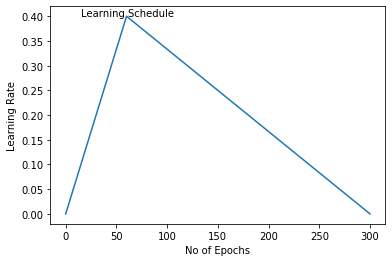

In [12]:
from matplotlib import pyplot as plt

p = plt.plot([0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])
plt.text(15, 0.4, "Learning Schedule")
plt.xlabel("No of Epochs")
plt.ylabel("Learning Rate")

####Optimizer

In [0]:
opt = tf.keras.optimizers.SGD(lr_func, momentum=MOMENTUM, nesterov=True)
#opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

####Data Augmentation
1. Do a random crop so that the image size is 32x32, same as cifar10 image size
2. Randomly flip an image horizontally (left to right). y is the seed value

This would make the model robust and prevent from overfitting

In [0]:
##random flip probability : 0.5 by default
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.image.random_crop(x, [32, 32, 3])), y)

####Training
The fit or fit_generator calls are not used for training.

GradientTape records the forward pass gradient computations
In the back propagation step the recorded values are used to update the trainable parameters.
Final data is printed in a formatted output. TQDM module provides a nice progress bar indication.

In [15]:
##Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
filePath = "/content/drive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_13/data/{}_epoch_{}_val_accuracy"

t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE 
    global_step = opt.apply_gradients(zip(grads, var))

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  #save the model every 50 epoch
  val_accuracy = test_acc / len_test
  if((epoch+51)//50 == 0):
    model.save_weights(filePath.format(epoch+1, val_accuracy))   
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)
  
  print('---->',val_accuracy)
  if(val_accuracy > 0.91 ):
    print('Exiting as val accuracy is > 91')
    break



epoch: 1 lr: 0.006666666666666667 train loss: 1.7959732695007324 train acc: 0.33876 val loss: 1.5411657600402833 val acc: 0.4337 time: 52.28769135475159
----> 0.4337



epoch: 2 lr: 0.013333333333333334 train loss: 1.0412612718200684 train acc: 0.62492 val loss: 0.8309852252960205 val acc: 0.7112 time: 100.58724594116211
----> 0.7112



epoch: 3 lr: 0.02 train loss: 0.7676242765808106 train acc: 0.7299 val loss: 0.9054317966461182 val acc: 0.7069 time: 148.75740838050842
----> 0.7069



epoch: 4 lr: 0.02666666666666667 train loss: 0.6439787953186035 train acc: 0.77634 val loss: 0.7777222797393799 val acc: 0.7393 time: 196.5796287059784
----> 0.7393



epoch: 5 lr: 0.03333333333333333 train loss: 0.562685308456421 train acc: 0.80566 val loss: 0.7328121284484863 val acc: 0.7487 time: 244.98374819755554
----> 0.7487



epoch: 6 lr: 0.04 train loss: 0.5121674149322509 train acc: 0.82304 val loss: 0.9205818044662476 val acc: 0.7031 time: 292.7280948162079
----> 0.7031



epoch: 7 lr: 0.04666666666666667 train loss: 0.4640158686065674 train acc: 0.83904 val loss: 0.7040731201171875 val acc: 0.7769 time: 340.83859491348267
----> 0.7769



epoch: 8 lr: 0.05333333333333334 train loss: 0.4299657681274414 train acc: 0.8527 val loss: 0.4945873162746429 val acc: 0.8262 time: 388.5481297969818
----> 0.8262



epoch: 9 lr: 0.060000000000000005 train loss: 0.39976162952423094 train acc: 0.86214 val loss: 0.6011318544387817 val acc: 0.8062 time: 436.4405314922333
----> 0.8062



epoch: 10 lr: 0.06666666666666667 train loss: 0.37432584590911866 train acc: 0.87028 val loss: 0.5296965250968934 val acc: 0.828 time: 484.1994090080261
----> 0.828



epoch: 11 lr: 0.07333333333333333 train loss: 0.3526471492767334 train acc: 0.8782 val loss: 0.5694459196090699 val acc: 0.8085 time: 531.8890426158905
----> 0.8085



epoch: 12 lr: 0.08 train loss: 0.3345010538864136 train acc: 0.88468 val loss: 0.4996803858757019 val acc: 0.8364 time: 580.4753136634827
----> 0.8364



epoch: 13 lr: 0.08666666666666667 train loss: 0.3127771022796631 train acc: 0.89088 val loss: 0.5961329463005066 val acc: 0.8073 time: 628.1739838123322
----> 0.8073



epoch: 14 lr: 0.09333333333333334 train loss: 0.2968768971252441 train acc: 0.89686 val loss: 0.5861821280956269 val acc: 0.8155 time: 675.9508395195007
----> 0.8155



epoch: 15 lr: 0.1 train loss: 0.28188834411621094 train acc: 0.90166 val loss: 0.41531350483894347 val acc: 0.8669 time: 723.9464728832245
----> 0.8669



epoch: 16 lr: 0.10666666666666667 train loss: 0.2678272449874878 train acc: 0.90652 val loss: 0.39727174419164657 val acc: 0.87 time: 771.7621722221375
----> 0.87



epoch: 17 lr: 0.11333333333333334 train loss: 0.25788222984313963 train acc: 0.90996 val loss: 0.37509471015930174 val acc: 0.8763 time: 819.6413860321045
----> 0.8763



epoch: 18 lr: 0.12000000000000001 train loss: 0.24333580640792846 train acc: 0.91576 val loss: 0.34640040521621707 val acc: 0.8859 time: 868.0588893890381
----> 0.8859



epoch: 19 lr: 0.12666666666666668 train loss: 0.23538661766052246 train acc: 0.91758 val loss: 0.45602909021377563 val acc: 0.8608 time: 915.4823360443115
----> 0.8608



epoch: 20 lr: 0.13333333333333333 train loss: 0.22203073476791382 train acc: 0.92286 val loss: 0.39802662525177 val acc: 0.8707 time: 962.9986600875854
----> 0.8707



epoch: 21 lr: 0.14 train loss: 0.2151111799621582 train acc: 0.92312 val loss: 0.3653250511646271 val acc: 0.8817 time: 1010.3595807552338
----> 0.8817



epoch: 22 lr: 0.14666666666666667 train loss: 0.2028682763671875 train acc: 0.92882 val loss: 0.4053435525894165 val acc: 0.8752 time: 1057.8929522037506
----> 0.8752



epoch: 23 lr: 0.15333333333333335 train loss: 0.19498664964675902 train acc: 0.93146 val loss: 0.35599176445007324 val acc: 0.8892 time: 1105.0832605361938
----> 0.8892



epoch: 24 lr: 0.16 train loss: 0.1897517104244232 train acc: 0.93388 val loss: 0.41775151937007904 val acc: 0.8755 time: 1152.3969311714172
----> 0.8755



epoch: 25 lr: 0.16666666666666669 train loss: 0.18311852088928224 train acc: 0.93502 val loss: 0.341338481259346 val acc: 0.8929 time: 1200.0802500247955
----> 0.8929



epoch: 26 lr: 0.17333333333333334 train loss: 0.17628882710456847 train acc: 0.93736 val loss: 0.38856345748901366 val acc: 0.8847 time: 1247.3306345939636
----> 0.8847



epoch: 27 lr: 0.18000000000000002 train loss: 0.17118431595802308 train acc: 0.94084 val loss: 0.349833874797821 val acc: 0.8917 time: 1294.1757502555847
----> 0.8917



epoch: 28 lr: 0.18666666666666668 train loss: 0.16307716025352478 train acc: 0.94286 val loss: 0.34678206415176394 val acc: 0.8973 time: 1341.5575382709503
----> 0.8973



epoch: 29 lr: 0.19333333333333336 train loss: 0.1598176922416687 train acc: 0.9428 val loss: 0.38831472482681273 val acc: 0.8868 time: 1388.8131129741669
----> 0.8868



epoch: 30 lr: 0.2 train loss: 0.1510212483882904 train acc: 0.9467 val loss: 0.36569062361717225 val acc: 0.8942 time: 1435.736415863037
----> 0.8942



epoch: 31 lr: 0.2066666666666667 train loss: 0.14726420311927796 train acc: 0.94822 val loss: 0.33560953311920166 val acc: 0.9026 time: 1483.3472566604614
----> 0.9026



epoch: 32 lr: 0.21333333333333335 train loss: 0.1403319163799286 train acc: 0.95008 val loss: 0.4851078145503998 val acc: 0.8654 time: 1530.3025789260864
----> 0.8654



epoch: 33 lr: 0.22 train loss: 0.14238247323036193 train acc: 0.95 val loss: 0.5668537737369538 val acc: 0.8525 time: 1577.2143256664276
----> 0.8525



epoch: 34 lr: 0.22666666666666668 train loss: 0.1335760507106781 train acc: 0.95382 val loss: 0.39519256734848024 val acc: 0.8854 time: 1624.1680433750153
----> 0.8854



epoch: 35 lr: 0.23333333333333334 train loss: 0.13229949563980103 train acc: 0.954 val loss: 0.37467901186943053 val acc: 0.8979 time: 1671.2275745868683
----> 0.8979



epoch: 36 lr: 0.24000000000000002 train loss: 0.12165993569374084 train acc: 0.95652 val loss: 0.3381103539466858 val acc: 0.8993 time: 1718.3210847377777
----> 0.8993



epoch: 37 lr: 0.24666666666666667 train loss: 0.12504234627723693 train acc: 0.9564 val loss: 0.35328357610702515 val acc: 0.8997 time: 1765.9786541461945
----> 0.8997



epoch: 38 lr: 0.25333333333333335 train loss: 0.11575532693862915 train acc: 0.95876 val loss: 0.37756128506660463 val acc: 0.8958 time: 1813.6646173000336
----> 0.8958



epoch: 39 lr: 0.26 train loss: 0.11567135918617248 train acc: 0.95916 val loss: 0.3914253849029541 val acc: 0.8923 time: 1859.660632133484
----> 0.8923



epoch: 40 lr: 0.26666666666666666 train loss: 0.1106492980003357 train acc: 0.96188 val loss: 0.37932667779922485 val acc: 0.8942 time: 1905.6909482479095
----> 0.8942



epoch: 41 lr: 0.2733333333333334 train loss: 0.11429003416538239 train acc: 0.96018 val loss: 0.34630324602127077 val acc: 0.9072 time: 1951.7283346652985
----> 0.9072



epoch: 42 lr: 0.28 train loss: 0.10847946113109588 train acc: 0.96196 val loss: 0.35434769043922426 val acc: 0.9034 time: 1997.776686668396
----> 0.9034



epoch: 43 lr: 0.2866666666666667 train loss: 0.10410219524383545 train acc: 0.96252 val loss: 0.41562415103912353 val acc: 0.8801 time: 2045.3300495147705
----> 0.8801



epoch: 44 lr: 0.29333333333333333 train loss: 0.10102869250297547 train acc: 0.96406 val loss: 0.3465084533691406 val acc: 0.9057 time: 2091.7354328632355
----> 0.9057



epoch: 45 lr: 0.30000000000000004 train loss: 0.09680689559459686 train acc: 0.96536 val loss: 0.3749268975734711 val acc: 0.8999 time: 2138.61497092247
----> 0.8999



epoch: 46 lr: 0.3066666666666667 train loss: 0.10081130432605744 train acc: 0.96434 val loss: 0.36157584295272827 val acc: 0.9015 time: 2184.84188580513
----> 0.9015



epoch: 47 lr: 0.31333333333333335 train loss: 0.09426684565782548 train acc: 0.9675 val loss: 0.3462065200805664 val acc: 0.9046 time: 2231.114070415497
----> 0.9046



epoch: 48 lr: 0.32 train loss: 0.08677467960357665 train acc: 0.96908 val loss: 0.3178760118484497 val acc: 0.9127 time: 2280.4866149425507
----> 0.9127
Exiting as val accuracy is > 91


In [17]:
model.summary()

Model: "resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn (ConvBN)             multiple                  1984      
_________________________________________________________________
conv_bn_1 (ConvBN)           multiple                  37120     
_________________________________________________________________
res_blk (ResBlk)             multiple                  111360    
_________________________________________________________________
res_blk_1 (ResBlk)           multiple                  370176    
_________________________________________________________________
res_blk_2 (ResBlk)           multiple                  1477632   
_________________________________________________________________
res_blk_3 (ResBlk)           multiple                  5904384   
_________________________________________________________________
global_max_pooling2d (Global multiple                  0  

####Accuracy

Validation Accuracy 92.82 in 706.6500709056854 seconds